In [1]:
!git clone https://github.com/kaapthijs/DMT-A1.git

Cloning into 'DMT-A1'...
remote: Enumerating objects: 86, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 86 (delta 27), reused 36 (delta 11), pack-reused 31
Receiving objects: 100% (86/86), 30.10 MiB | 12.98 MiB/s, done.
Resolving deltas: 100% (41/41), done.
Updating files: 100% (11/11), done.


In [2]:
import os
os.chdir('DMT-A1')

In [3]:
import pandas as pd
import numpy as np
from feature_engineering import create_features,select_features
import random

#SEED = np.random.randint(100)
SEED = 60
np.random.seed(SEED), random.seed(SEED)
print(f"SEED: {SEED}")
#pd.set_option('future.no_silent_downcasting', True)
dataset = pd.read_csv('./cleaned_dataset.csv')
# Creating features
X, y = create_features(dataset,window_size=1)

SEED: 60


In [42]:
X.shape, y.shape
X['mood_final'] = y
X.shape, y.shape

((1304, 33), (1304, 1))

In [43]:
#create sequences for the LSTM
def create_sequences(X, y, sequence_length=5):
    X_final= []
    y_final = []
    for i in range(len(X) - sequence_length):
        X_final.append(X.iloc[i:i + sequence_length, :].values)
        y_final.append(y.iloc[i:i + sequence_length])
    return np.array(X_final), np.array(y_final)

X_seq, y_seq = create_sequences(X, y, sequence_length=5)

In [44]:
from sklearn.model_selection import train_test_split

#custom train test split for sequential data
def train_test_split_custom(data, train_size=0.8):
    split_idx = int(len(data) * train_size)
    train = data[:split_idx]
    test = data[split_idx:]
    return train, test


'''
X_train, X_test = train_test_split(X_seq, train_size=0.75, stratify = (y_seq[:,-1] > 7.5).astype(int))
y_train, y_test = train_test_split(y_seq, train_size=0.75,stratify = (y_seq[:,-1] > 7.5).astype(int))
X_train.shape,y_train.shape, X_test.shape,y_test.shape
'''
X_train, X_test = train_test_split_custom(X_seq, train_size=0.8)
y_train, y_test = train_test_split_custom(y[5:], train_size=0.8)
X_train.shape,y_train.shape, X_test.shape,y_test.shape


((1039, 5, 33), (1039, 1), (260, 5, 33), (260, 1))

In [45]:
y_train.head()

,mood
5,6.146341
6,7.812500
7,7.818182
8,7.750000
9,6.272727


In [46]:
#create sequences for the LSTM
def create_sequences(X, y, sequence_length=5):
    X_final= []
    y_final = []
    for i in range(len(X) - sequence_length):
        X_final.append(X.iloc[i:i + sequence_length, :].values)
        y_final.append(y.iloc[i:i + sequence_length])
    return np.array(X_final), np.array(y_final)

X_seq, y_seq = create_sequences(X, y, sequence_length=5)


In [47]:
from sklearn.model_selection import train_test_split

#custom train test split for sequential data
def train_test_split_custom(data, train_size=0.8):
    split_idx = int(len(data) * train_size)
    train = data[:split_idx]
    test = data[split_idx:]
    return train, test


'''
X_train, X_test = train_test_split(X_seq, train_size=0.75, stratify = (y_seq[:,-1] > 7.5).astype(int))
y_train, y_test = train_test_split(y_seq, train_size=0.75,stratify = (y_seq[:,-1] > 7.5).astype(int))
X_train.shape,y_train.shape, X_test.shape,y_test.shape
'''
X_train, X_test = train_test_split_custom(X_seq, train_size=0.8)
y_train, y_test = train_test_split_custom(y[5:], train_size=0.8)
X_train.shape,y_train.shape, X_test.shape,y_test.shape

X_train.shape,y_train.shape, X_test.shape,y_test.shape

((1039, 5, 33), (1039, 1), (260, 5, 33), (260, 1))

In [48]:
#normalize the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X_train.reshape(-1,X_train.shape[2]))

X_train_scaled = scaler.transform(np.reshape(X_train, (-1, X_train.shape[2])))
X_test_scaled = scaler.transform(np.reshape(X_test, (-1, X_test.shape[2])))

# Reshape back to the original dimensions
X_train_scaled = np.reshape(X_train_scaled, X_train.shape)
X_test_scaled = np.reshape(X_test_scaled, X_test.shape)

In [49]:
from tensorflow.keras.layers import Dropout, LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.layers import GRU



timesteps = X_train_scaled.shape[1]  # Number of timesteps in the input/output sequence
features = X_train_scaled.shape[2] # Number of features in the input
output_units = 1  # Output dimension (1 for binary classification at each timestep)




model = Sequential([
    LSTM(50, input_shape=(timesteps, features)),
    Dropout(0.5),
    Dense(1, activation='linear')
])
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mean_absolute_error'])
model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 50)                16800     
                                                                 
 dropout_4 (Dropout)         (None, 50)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 51        
                                                                 
Total params: 16851 (65.82 KB)
Trainable params: 16851 (65.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [56]:
history = model.fit(
    X_train_scaled,
    y_train,            # Training data and labels
    epochs=20,                   # Number of epochs to train for
    batch_size=16,               # Batch size for training
    validation_split=0.2,        # Fraction of data to use for validation
    verbose=1,                   # Show detailed progress in the output

)


Epoch 1/20
52/52 [==============================] - 1s 12ms/step - loss: 0.9828 - mean_absolute_error: 0.9828 - val_loss: 0.4304 - val_mean_absolute_error: 0.4304
Epoch 2/20
52/52 [==============================] - 0s 6ms/step - loss: 0.9223 - mean_absolute_error: 0.9223 - val_loss: 0.4257 - val_mean_absolute_error: 0.4257
Epoch 3/20
52/52 [==============================] - 0s 6ms/step - loss: 0.9048 - mean_absolute_error: 0.9048 - val_loss: 0.4821 - val_mean_absolute_error: 0.4821
Epoch 4/20
52/52 [==============================] - 0s 7ms/step - loss: 0.9159 - mean_absolute_error: 0.9159 - val_loss: 0.4286 - val_mean_absolute_error: 0.4286
Epoch 5/20
52/52 [==============================] - 0s 6ms/step - loss: 0.8946 - mean_absolute_error: 0.8946 - val_loss: 0.4485 - val_mean_absolute_error: 0.4485
Epoch 6/20
52/52 [==============================] - 0s 7ms/step - loss: 0.9110 - mean_absolute_error: 0.9110 - val_loss: 0.5437 - val_mean_absolute_error: 0.5437
Epoch 7/20
52/52 [=========

In [57]:
y_pred = model.predict(X_test_scaled)

9/9 [==============================] - 0s 4ms/step


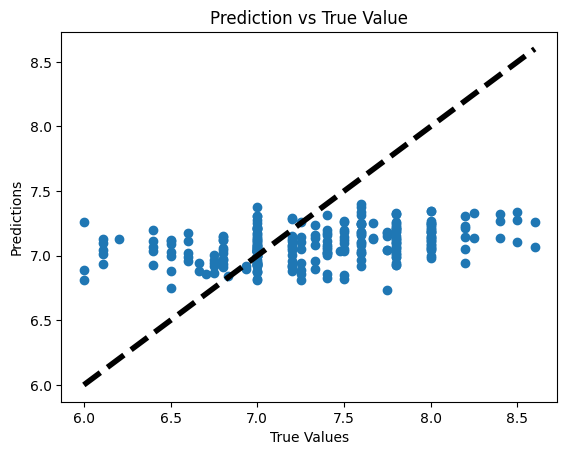

In [58]:
import matplotlib.pyplot as plt

# Assuming y_pred and y_test are available
plt.scatter(y_test, y_pred)
plt.title('Prediction vs True Value')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)  # Diagonal line
plt.show()


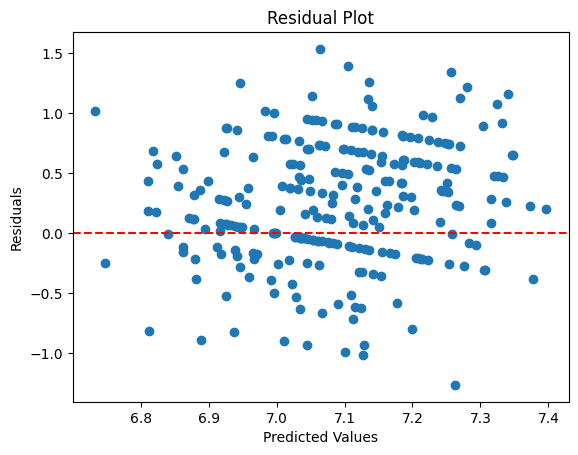

In [59]:
residuals = y_test - y_pred
plt.scatter(y_pred, residuals)
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='red', linestyle='--')
plt.show()


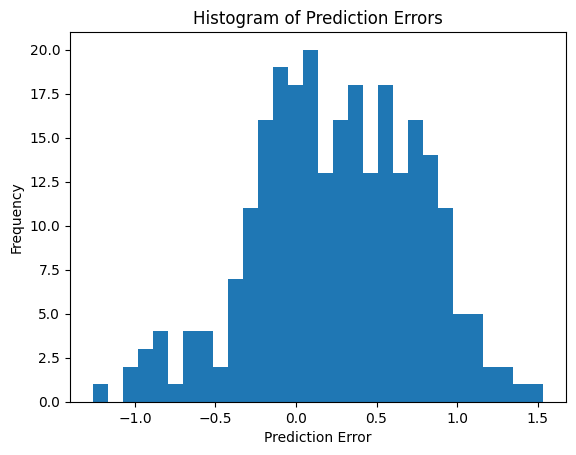

In [60]:
plt.hist(residuals, bins=30)
plt.title('Histogram of Prediction Errors')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.show()



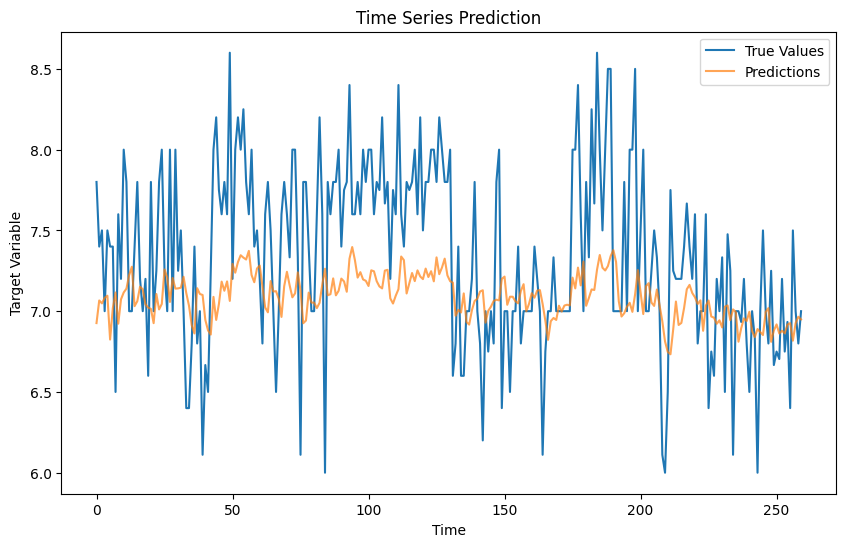

In [61]:
plt.figure(figsize=(10, 6))
plt.plot(y_test.reset_index(drop=True), label='True Values')
plt.plot(y_pred, label='Predictions', alpha=0.7)
plt.title('Time Series Prediction')
plt.xlabel('Time')
plt.ylabel('Target Variable')
plt.legend()
plt.show()